# Demonstration of the usage of vita-python utilities
This notebook demonstrate three major usages:
1. Define area using numpy 3d array and save it as `.vtk` file for VItA vessel synthesis
2. Synthesize vessels based on docker containerized VItA
3. Voxelize the generated `vessel.vtp` file to produce the 3d numpy.ndarray

For more information about the `VItA` and `vita docker container`,\
Please check the `README.md` of this repo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Define vessel synthesis area

In [2]:
from vita_python_utils import random_index_of_one, save_np_vtk

In [3]:
## Create the volume with a sphere
x, y, z = np.ogrid[:50, :50, :50]
dx = 1
dist_sq = (x - 25)**2 + (y - 25)**2 + (z - 25)**2
sphere_mask = dist_sq <= 20**2

In [4]:
## Save the volume as vtk file
save_path = 'demo/sphere'
final_vtk_path = save_np_vtk(sphere_mask, save_path, spacing=dx, smooth=True, filetype='vtk')

Running marching cubes to generate mesh...
The mesh is watertight (closed).
Original mesh: 7542 vertices.
Smoothing the generated mesh using `trimesh`...
Smoothed mesh: 7542 vertices.
Workflow complete. The file is ready. Saved as 'demo/sphere.vtk'


In [5]:
## Define the vessel origin
ves_pos = random_index_of_one(sphere_mask)*dx
print(ves_pos)

[34 20 35]


## Using VItA to generate vessel

In [6]:
from vita_python_utils import gen_vita_docker_com, run_vita_with_monitoring

In [7]:
# set vessel synthesis parameters
num_ves = 50
prefix = 'demo_gen_sphere'

# enter the absolute path. This folder has to be mount-able by the docker
# in addition, this folder should be the folder that include the .vtk file
# and will be the folder where the .vtp files are saved
vita_folder = '/scratch/hkhuang3/vita_python_utils/example/demo/'

# prepare docker commands
docker_com = gen_vita_docker_com(ves_pos, num_ves,
                                 gen_prefix=prefix,
                                 vtk_name='sphere.vtk',
                                 vita_path=vita_folder)
print(docker_com)

['docker', 'run', '--rm', '-v', '/scratch/hkhuang3/vita_python_utils/example/demo:/app/vita_example', 'kevinh0718/vita_talou_cco:latest', 'sh', '-c', 'cd /app/vita_example && ./vessel_synthesis 34 20 35 50 demo_gen_sphere sphere.vtk 0']


In [8]:
# execute the vita generation 
for _ in range(3):
    if run_vita_with_monitoring(docker_com, max_count=3, print_all=1):
        print("Generation succeed")
        break

[MONITOR] Found termination trigger. Count: 1/3
Generation succeed


## Voxelize the generated vessels

In [9]:
from vita_python_utils import tubify_mesh, to_structured_grid_parallel

In [10]:
# load the vtp file
filepath = vita_folder+prefix+'.vtp'
mesh = tubify_mesh(filepath, 0.1) # determine the basic vessel thickness

In [11]:
import time
curr = time.time()
fr = 5 # use finer grid to visualize the vasculature
vasculature = to_structured_grid_parallel(mesh, (fr*50, fr*50, fr*50),
                                   (fr*0,fr*0,fr*0), 1.0/fr, parallel_axis=0,
                                   num_slices=60)
print("It took ", time.time()-curr, " seconds.")

Slice 51 exceeds volume bounds. Stopping slice generation.
Splitting volume into 50 slices and processing with 64 workers.
Parallel processing complete. Volume stitched.
It took  5.434266805648804  seconds.


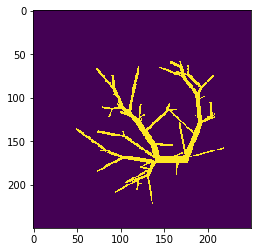

In [12]:
imgdata = np.max(vasculature, axis=1)
plt.imshow(imgdata, interpolation='nearest')